In [1]:
import warnings
warnings.filterwarnings('ignore')

# Classfication

Input vector $\mathbb{x}=(x_1,...,x_m)$와, input vertor가 속할 수 있는 category list $\mathbb{y}=\{1,...,k\}$가 주어졌다고 가정하자. Classification은 input data $\mathbb{x}$에 대해서, $\mathbb{x}$가 $k$개의 카테고리 중에서 어디에 속하는지 결정하고 대응시켜주는 task이다. Leaning 알고리즘은 $\mathbb{x}$와 $\mathbb{x}$가 대응되는 카테고리를 mapping 하는 함수를 학습한다. 함수는 다음과 같이 표현된다. 
$$f:\mathbb{R}^n \to \{1,...,k\}$$

# Classifier의 종류
- Naive Bayesian Classifier
- Logistic Regression
- Decsion Tree
- Ensemble model
 - Bagging
 - Random forest 
 - Gradient Boosting
 - Adaboost
 - XGBoost
- SVM
- Perceptron
- Deep Neural Network

# MNIST와 scikit-learn을 활용한 binary classification tutorial

## 1. MNIST

- 70,000개의 숫자 이미지
- 각 이미지에 어떤 숫자가 대응되는지 labeling (0, ... ,9 까지의 정수)
- 새로운 분류 알고리즘이 나올 때마다 MNIST 데이터 셋에서 얼마나 잘 작동하는지를 테스트
- 머신러닝 알고리즘 영역의 hello world 데이터 셋

<img src="https://i2.wp.com/sefiks.com/wp-content/uploads/2017/09/mnist.png?resize=289%2C289&ssl=1" width="400" height="400">

### 1.1 Keras를 이용하여 데이터 셋 불러오기

In [2]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Using TensorFlow backend.


In [3]:
x_train.shape

(60000, 28, 28)

In [4]:
x_test.shape

(10000, 28, 28)

- 이미지는 총 70,000개 (train : 60,000개 / test : 10,000개)
- Feature의 갯수(pixel의 갯수)는 784개 ($28 \times 28$)이며, 각 entry는 0~255까지의 픽셀 강도를 나타냄

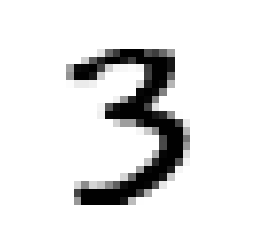

In [5]:
# 이미지 데이터를 plotting
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

digit = x_train[10000]
plt.imshow(digit, cmap=matplotlib.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()

In [6]:
# 그 이미지의 label
y_train[10000]

3

> Tip : **Training set을 섞어서 모든 교차 검증 폴드가 비슷하게 만들어야 한다. (즉, 특정 폴드에서, 특정 숫자가 누락되면 안된다.)**
     - 데이터셋을 랜덤하게 섞는다.
     - 특정 카테고리에 속하는 데이터가 연속적으로 나오지 않도록 한다. (모델이 순서를 학습할 수 있다.)
     - 단, 시계열 데이터는 섞으면 안된다.

## 2. Binary classification

문제를 단순하게 하기 위해서,
 - 숫자 5이다.
 - 숫자 5가 아니다.
 
로 분류

In [7]:
y_train_5 = (y_train == 5)  # 5는 True, 그 외는 False
y_test_5 = (y_test == 5)  # 5는 True, 그 외는 False

In [8]:
y_train_5[:5]

array([ True, False, False, False, False])

In [9]:
print(x_train.shape)
print(y_train_5.shape)

(60000, 28, 28)
(60000,)


### 2.1 SGDClassifier (Stochastic Gradient Descent Classifier)
확률적 경사 하강법 분류기 : 하나의 독립된 훈련 샘플을 처리하고 모델을 업데이트

In [10]:
# 확률적 경사 하강법 분류기를 사용하기 위해서는 input shape이 2 dim 이어야 한다.
import numpy as np

x_train_2d = np.reshape(x_train, (-1, 784))
x_test_2d = np.reshape(x_test, (-1, 784))

In [11]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(max_iter=5, random_state=42)
# 훈련
sgd.fit(x_train_2d, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [12]:
# 결과 check
pred = sgd.predict([x_train_2d[10]])
print('Prediction: ', pred)
print('Actual: ', y_train_5[10])

Prediction:  [False]
Actual:  False


## 3. Performance 측정

### 3-1. 교차 검증을 사용한 정확도 측정

모델이 학습되는 동안 overfitting을 확인 및 성능을 평가하기 위하여, 즉 모델의 학습 정도를 확인하기 위하여 validation set이 필요하다.

Validation data를 생성하기 위해서, training data의 부족 현상이 발생할 수 있다. 이런 경우는 학습이 충분히 제대로 이루어지지 않는다. Training data가 부족하다면, validation set을 어떻게 확보할 수 있을까?
- Multi($K$)-fold cross validation : Dataset을 $K$개의 부분 집합으로 나눈다. 하나의 부분집합을 validation set으로 사용하고, 나머지 $K-1$개의 부분집합을 training set으로 활용한다. 이 과정을 $K$번 반복한다. $K$번의 validation check가 가능하고 그 중 가장 작은 validation error를 보이는 모델을 선택한다. 물론 각 과정에서 training set과 validation set은 mutually exclusive하다. 학습 과정중에서 $K$개의 다양한 모델을 만들면서 학습하기 때문에 시간의 trade off가 발생한다.
- Leave-one-out cross-validation : Dataset의 크기가 $n$ 이라면 1개의 data sample을 validation data로 사용하고 $n-1$개의 데이터를 training set으로 사용한다. $n$번 validation을 수행한 후, error를 계산한다.

> Customizing이 가능한 코드 (sklearn의 cross val score와 동일한 일을 수행한다.)

In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# 데이터의 각 class 별 비율을, fold에서 맞추어준다.
skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(x_train_2d, y_train_5):
    clone_sgd = clone(sgd)
    x_train_folds = x_train_2d[train_index]
    y_train_folds = y_train_5[train_index]
    x_test_folds = x_train_2d[test_index]
    y_test_folds = y_train_5[test_index]
    
    clone_sgd.fit(x_train_folds, y_train_folds)
    y_pred = clone_sgd.predict(x_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct / len(y_pred))

0.9532
0.95125
0.9625


> `cross_val_score`를 이용한다.

In [14]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd, x_train_2d, y_train_5, cv=3, scoring='accuracy')

array([0.9532 , 0.95125, 0.9625 ])

왜 이렇게 성능이 높을까?

In [15]:
from collections import Counter
print('Training set:', Counter(y_train_5))
print('Test set:', Counter(y_test_5))

Training set: Counter({False: 54579, True: 5421})
Test set: Counter({False: 9108, True: 892})


이렇게 **불균형한 데이터를 다룰때**는 분류기의 성능 지표로 accuracy가 과연 좋을까?

### 3-2 오차 행렬 (Confusion matrix)
 - 클래스 A의 샘플이 클래스 B로 분류된 횟수를 세는 것

In [16]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd, x_train_2d, y_train_5, cv=3)

In [17]:
x_train_2d.shape

(60000, 784)

`cross_val_predict`: K-fold 교차 검증을 수행하지만, 평가점수를 반환하지 않고, 예측값을 반환한다.

In [18]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[52992,  1587],
       [ 1074,  4347]])

- confusion matrix의 row : 실제 클래스
- confusion matrix의 column : 예측한 클래스

| Confusion mtx | Prediction(0, $H_0$)| Prediction(1, $H_1$) |
| :----------------------: |:-------------------:| :--------------------: |
| Actual class(0, $H_1$) | True Negative | False Positive |
| Actual class(1, $H_0$) | False Negative | True Positive |

### 3-3 F1 score

#### Precision, 정밀도

- $\text{Precision}=\frac{TP}{TP+FP}$

- 분류기가 "1"이라고 예측한 샘플 중에서, 실제 값이 "1"이 샘플의 비율

#### Recall, 재현율 (또는 Sensitivity, 민감도, True Positive Rate, 진짜 양성 비율)
 - $\text{Recall}=\frac{TP}{TP+FN}$
 - 실제 값이 "1"인 샘플 중에서, 분류기가 "1"이라고 예측한 비율

In [19]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.7325581395348837

5로 판별된 샘플중에서 73%로만 정확

In [20]:
recall_score(y_train_5, y_train_pred)

0.8018815716657444

전체 5에서 80%만 감지

#### $F_1$ socre
- Precision과 Recall의 조화 평균(harmonic mean)
- $F_1=\frac{2}{\frac{1}{\text{Precision}}+\frac{1}{\text{Recall}}}=2\times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}=\frac{TP}{TP+\frac{FN+FP}{2}}$

In [21]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.765653896961691

과연 $F_1$ score가 높은 것이 항상 좋을까?
 - 어린아이에게 안전한 동영상을 걸러내는 분류기를 훈련
  - 좋은 동영상의 Recall은 낮아도, 좋은 동영상의 Precision이 높도록
 - 카메라를 통해 좀도둑을 잡아내는 분류기
  - 좀도둑의 Precision은 낮아도, 좀도둑의 recall은 높도록

### 3-4 Precision/Recall trade off

SGDClassifier가 분류를 결정하는 방법 : Decision function (결정 함수)를 사용하여 각 샘플의 점수를 계산
 - 샘플의 점수 $\geq$ 임계값(threshold) : 양성 클래스에 할당
 - 샘플의 점수 < 임계값(threshold) : 음성 클래스에 할당

In [22]:
# 결정 함수에 사용된 점수를 확인
y_scores = sgd.decision_function([x_train_2d[0]])
y_scores

array([-45148.19955869])

In [23]:
y_train_pred[0]

True

In [24]:
y_test_5[0]

False

만약에 임계값을 변경하게 되면 예측값이 변화하게 되고, precision / recall이 변하게 된다. 따라서 적절한 임계값을 정하는것이 중요하다.

In [25]:
y_scores = cross_val_predict(sgd, x_train_2d, y_train_5, cv=3, method='decision_function') 

In [26]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

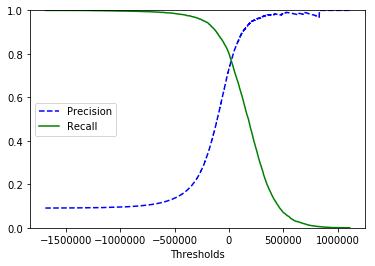

In [27]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Thresholds')
    plt.legend(loc='center left')
    plt.ylim([0, 1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

Text(0,0.5,'Precision')

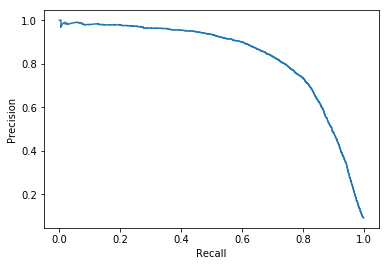

In [28]:
# Precision, recall graph를 그려보자.
plt.plot(recalls[:-1], precisions[:-1])
plt.xlabel('Recall')
plt.ylabel('Precision')

Recall이 0.8일때 precision이 급격하게 줄어들기 때문에, precision을 중요시하는 모델을 생성하기 위해서는, 0.6~0.7 정도의 recall을 달성하는 theshold를 선택하는 것이 좋다. 이렇게 threshold를 customizing하기 위해서는 `predict()` 메소드를 호출하지 말고, `y_train_pred = (y_scores > new threshold)`처럼 한다.

In [29]:
y_train_pred_new_thre = (y_scores > 70000)

In [30]:
precision_score(y_train_5, y_train_pred_new_thre)

0.8415374241402562

In [31]:
recall_score(y_train_5, y_train_pred_new_thre)

0.6906474820143885

### 3-5 ROC 곡선

- **Receiver Operating Characteristic(ROC)** 곡선은 binary classification에 널리 사용되는 도구
- **FPR에 대한 TPR의 곡선**
 - FPR : False Positive Rate, 거짓 양성 비율, 양성(1)로 잘못 분류된 음성(0)의 비율, $\frac{FP}{FP+TN}$, 1-specificity(TNR, 특이도)
 - TPR : True Positive Rate, Recall, Sensitivity, 진짜 양성 비율

In [32]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

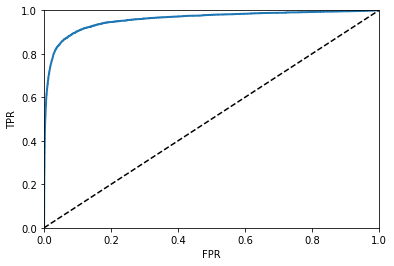

In [33]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('FPR')
    plt.ylabel('TPR')

plot_roc_curve(fpr, tpr, 'SGD')
plt.show()

Recall이 증가하면, 분류기가 양성으로 분류하는 경향이 커지기 때문에, FPR도 증가한다. 즉, Recall이 높을수록 분류기가 만드는 FPR이 증가한다. 좋은 분류기는 왼쪽 오른쪽 모서리에 가까워지며, 대각선의 점선과는 멀어져야한다.

In [34]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9584692857783504

양성 클래스 sample이 드물거나, 거짓 음성보다 거짓 양성이 더 중요할 때는 Precision-Recall graph를 사용하고, 그렇지 않을 때는 ROC 곡선을 사용한다.

### 3-4. 다른 모델과의 성능 비교
- RandomforestClassifier vs SGDClassifier

In [35]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
y_prob_rf = cross_val_predict(rf, x_train_2d, y_train_5, cv=3, method='predict_proba')

In [36]:
# 확률값으로 나오기 때문에, 양성 클래스에 대한 확률을 점수로 사용함
y_scores_rf = y_prob_rf[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_train_5, y_scores_rf)

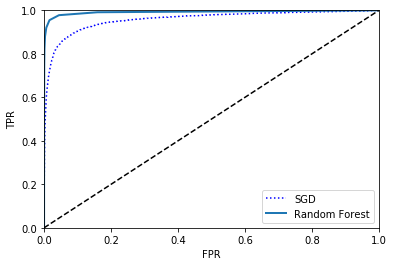

In [37]:
plt.plot(fpr, tpr, 'b:',label='SGD')
plot_roc_curve(fpr_rf, tpr_rf, 'Random Forest')
plt.legend(loc='lower right')
plt.show()

#### ROC_AUC socre

In [38]:
roc_auc_score(y_train_5, y_scores_rf)

0.9920527492698306

#### Precision, Recall

In [39]:
precision_score(y_train_5, (y_scores_rf > 0.5))

0.986046511627907

In [40]:
recall_score(y_train_5, (y_scores_rf > 0.5))

0.8212506917542889